## Singular-value decomposition

### Implementation and appplication

This notebook i) introduces the main practical aspects of computing the SVD of rectangular matrices, ii) runs examples applications and iii) shows a visual assessment of the error introduced by matrix decomposition.

#### SVD example

Today SVD is available from the `scipy` Python module, namely `scipy.linalg.svd`.

Let's see how it works on our example activity matrix. 

![](https://github.com/ale66/learn-datascience/blob/main/week-1/notation_maths/imgs/activity_matrix.png?raw=true)


$\mathbf{A} = \begin{pmatrix}
1 & 1 & 1 & 0 & 0 \\
3 & 3 & 3 & 0 & 0 \\
4 & 4 & 4 & 0 & 0 \\
5 & 5 & 5 & 0 & 0 \\
0 & 0 & 0 & 4 & 4 \\
0 & 0 & 0 & 5 & 5 \\
0 & 0 & 0 & 2 & 2
\end{pmatrix}$

#### Import modules and prepare data

In [69]:
import numpy as np


In [70]:
m = 7
n = 5

A = np.array([[1,1,1,0,0],
     [3,3,3,0,0], 
     [4,4,4,0,0], 
     [5,5,5,0,0], 
     [0,0,0,4,4], 
     [0,0,0,5,5], 
     [0,0,0,2,2]
     ],
     dtype=int
    )


In [71]:
from scipy.linalg import svd

Now, the `numpy` function performs the SVD decomposition $A = U D V^T$. 


In [72]:
# Check scipy documentation
U, singular_vals, V_t = svd(A)

The second element is not a diagonal matrix, but a vector of singular values; so we will create D below

##### Let's visualise the result

In [73]:
# notice the Numpy piecewise division
U_truncated = np.trunc(U * 100) / 100

print(f'U (truncated to 2 decimals)=\n{U_truncated}')


U (truncated to 2 decimals)=
[[-0.14  0.    0.41 -0.56 -0.42  0.52  0.2 ]
 [-0.42  0.    0.15 -0.2   0.84  0.19  0.07]
 [-0.56  0.    0.2   0.72 -0.2   0.25  0.1 ]
 [-0.7   0.   -0.33 -0.34 -0.25 -0.42 -0.16]
 [ 0.   -0.59  0.64  0.    0.   -0.44 -0.17]
 [ 0.   -0.74 -0.44  0.    0.    0.44 -0.22]
 [ 0.   -0.29 -0.17  0.    0.   -0.22  0.91]]


Let's build the central matrix, which has the same shape as the original matrix. 

Some rows might be zero: the respective eigenvalue was zero.

In [74]:
# put the singular values into the diagonal
D = np.zeros((m, n), dtype=float)

for i in range(min(m, n)):
    D[i,i] = singular_vals[i]

print(D.shape)

D_truncated = np.trunc(D * 1000) / 1000

print(f'D (truncated to 3 decimals)=\n{D_truncated}')

(7, 5)
D (truncated to 3 decimals)=
[[12.369  0.     0.     0.     0.   ]
 [ 0.     9.486  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]]


In [75]:
V_t_truncated = np.trunc(V_t * 100) / 100

print(f'V^T (truncated to 2 decimals)=\n{V_t_truncated}')

V^T (truncated to 2 decimals)=
[[-0.57 -0.57 -0.57 -0.   -0.  ]
 [-0.   -0.   -0.   -0.7  -0.7 ]
 [ 0.    0.    0.   -0.7   0.7 ]
 [ 0.   -0.7   0.7   0.    0.  ]
 [ 0.81 -0.4  -0.4   0.    0.  ]]


#### How much numerical error was introduced?

This is a tiny matrix of integeers, so we hope that the SVD decomposition will work well.

In [76]:
A_reconstructed = np.dot(U, np.dot(D, V_t))

A_reconstructed_trunc = np.trunc(A_reconstructed * 1000) / 1000

print(f'A_reconstructed (truncated to 3 decimals)=\n{A_reconstructed_trunc}')


A_reconstructed (truncated to 3 decimals)=
[[0.999 0.999 0.999 0.    0.   ]
 [3.    3.    3.    0.    0.   ]
 [4.    4.    4.    0.    0.   ]
 [5.    5.    5.    0.    0.   ]
 [0.    0.    0.    3.999 3.999]
 [0.    0.    0.    4.999 4.999]
 [0.    0.    0.    1.999 1.999]]


### Value estimation (with the Moore-Penrose pseudo-inverse)

Thanks to the SVD, the Moore-Penrose pseudo-inverse can be computed and deployed to estimate the values of the missing entries in the matrix A. 

Remember the basic steps:

$A\vec{x} = \vec{v}$

$A^+A\vec{x} = A^+\vec{v}$

$I\vec{x} \approx A^+\vec{v}$

We compute $A^+\vec{v}$ and use it for value estimantion.

Thanks to the SVD, $A^+$ has simplified formulation:

$A^+ = VD^+U^T$

Thankfully, we have $V^T$ and $U$ from before, whereas $D^+$ is easily extracted from $D$: 

for each non-zero element $d_{ii}=\sqrt{\lambda_i}$ put its inverse $\frac{1}{\sqrt{\lambda_i}}$ in the same position of $D^+$. 

Then fill the rest with 0.

$\mathbf{D^+} = \begin{pmatrix}
\frac{1}{\sqrt{\sigma_1}} & 0 & 0 & 0 & 0 \\
0 & \frac{1}{\sqrt{\sigma_2}} & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0
\end{pmatrix}$

In [77]:
# These assignments are not striclty necessary, but hopefully will increase readability
U_t = U.T

V = V_t.T

In [78]:
# construct the D+ of D

D_plus = np.zeros((n, m), dtype=float)

for i in range(min(m, n)):
    
    # use condition '> 1e-6' to avoid big values.
    if D[i,i] != 0:
        D_plus[i,i] = 1 / D[i,i]


In [79]:
# we are ready to compute the pseudo-inverse
A_plus = np.dot(V, np.dot(D_plus, U_t))


Now value estimation begins

We have a new user, Julia, who has not rated any of the items yet. 

Let's deploy SVD to estimate her ratings.

The regression/value estimation is formulated as:

$\hat{y} = a_0 + a_1 x$ 

such that the error function is minimized on the known data points:

$\sum_{i=1}^m (y_i - \hat{y}_i)^2$ 


To do so, we seek to minimise 

$A\vec{x} - v$


Thanks to SVD, the solution is simply:
    
$\vec{x} = A^+\vec{v}$

In [80]:
x = np.dot(A_plus, A[:, -1].T)

print(x)

[0.  0.  0.  0.5 0.5]


### Image factorization with SVD

We know look at SVD of images.

Idea: after SVD, drop the singular values with value 0 or very close to 0 and keep a reduced version of the image which nonetheless should be recognisable. 

This can be interpreted as the highest-value singular values (and their eigenvectors) capturing what is essential in the image.

But how many singular values should we keep?

In [81]:
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces

In [82]:
faces = fetch_olivetti_faces(shuffle=True, random_state=42)

dir(faces)

['DESCR', 'data', 'images', 'target']

In [83]:
olivetti_images = faces.images

image = None

In [84]:
# define the size of the image matrix
# (64, 64) pixels
IMG_SIZE = 64

ROWS = 4

COLS = 3

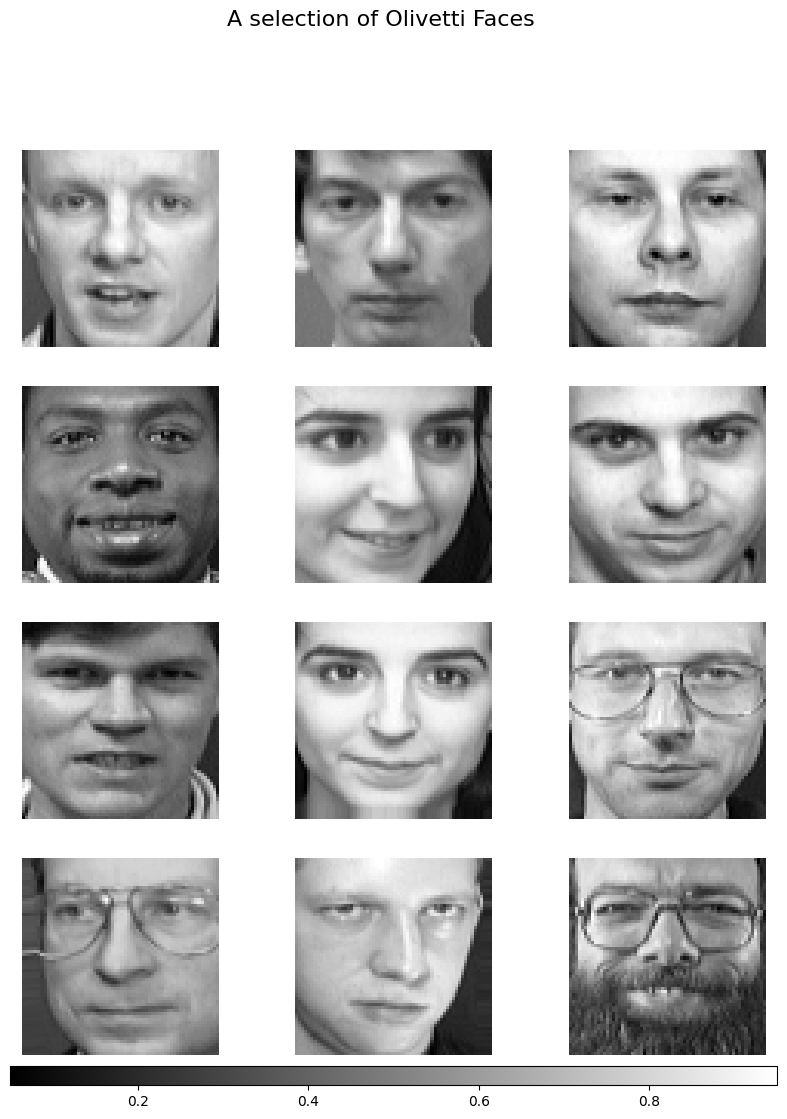

In [85]:
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10, 14))

for ax, img in zip(axes.flat, olivetti_images):
    image = ax.imshow(img, cmap="gray")
    fig.suptitle("A selection of Olivetti Faces", size=16)
    ax.axis("off")

if image is not None:
    fig.colorbar(image, ax=axes, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    
plt.show()

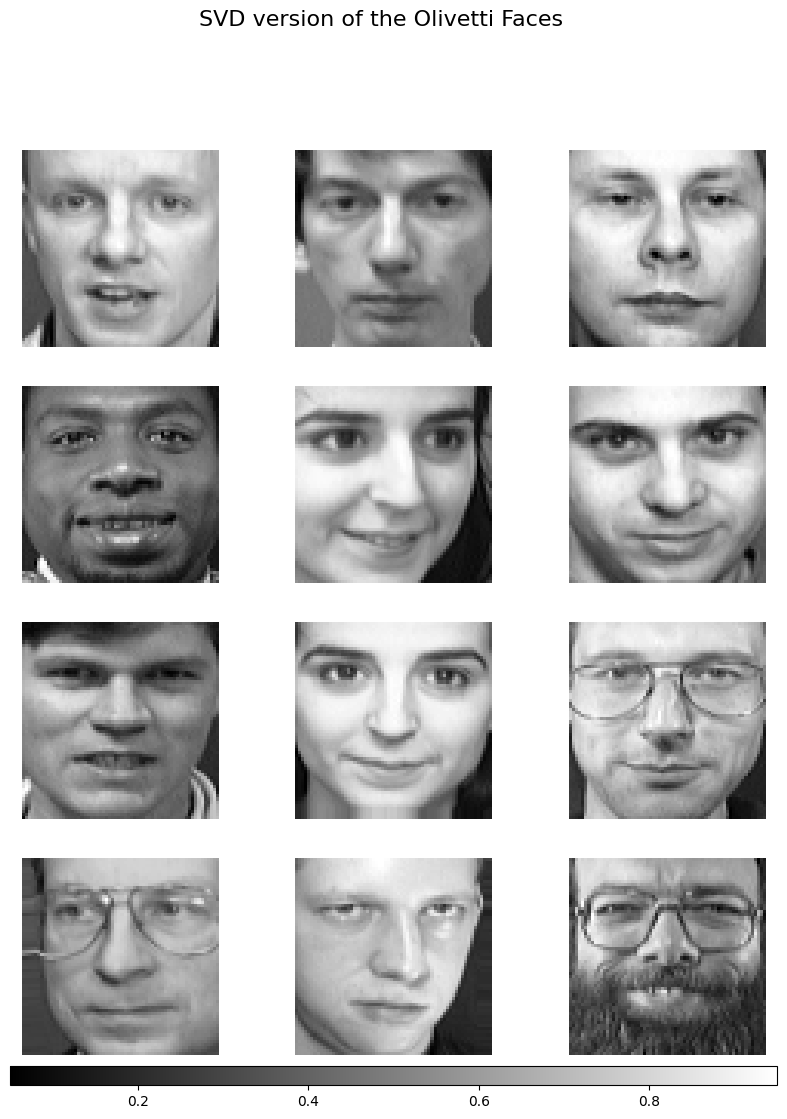

In [86]:
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10, 14))

for ax, img in zip(axes.flat, olivetti_images):
    U, singular_vals, V_t = np.linalg.svd(img, full_matrices=False)
    
    # put the singular values into the diagonal
    D = np.zeros((IMG_SIZE, IMG_SIZE), dtype=float)

    for i in range(IMG_SIZE):
        D[i,i] = singular_vals[i]

    img_reconstructed = np.dot(U, np.dot(D, V_t))
    
    image = img_reconstructed
    image = ax.imshow(image, cmap="gray")
    fig.suptitle("SVD version of the Olivetti Faces", size=16)
    ax.axis("off")

if image is not None:
    fig.colorbar(image, ax=axes, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    
plt.show()

#### Parameter tuning

We can modify the code to reconstruct each image using only the *top-k* singular values.

As $k< \min\{n,m\}$ we achieve SVD compression.

In [92]:
# this is the number of singular values to be tuned downward
K = 20

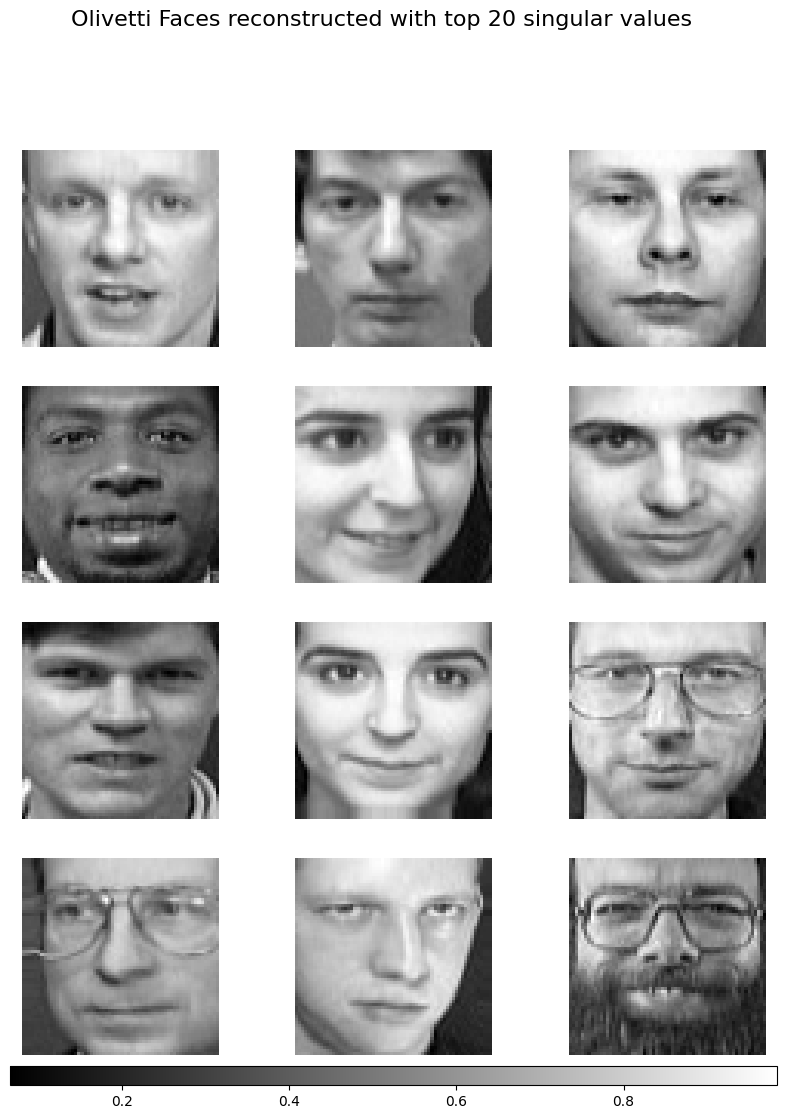

In [93]:
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10, 14))

for ax, img in zip(axes.flat, olivetti_images):

    U, singular_vals, V_t = np.linalg.svd(img, full_matrices=False)

    # Keep only top k singular values
    U_k = U[:, :K]                   # First k columns of U
    
    D_k = np.diag(singular_vals[:K])  # Diagonal matrix of top k singular values
    
    V_t_k = V_t[:K, :]              # First k rows of V^T

    # Reconstruct image using top-K components
    img_reconstructed = np.dot(U_k, np.dot(D_k, V_t_k))

    image = ax.imshow(img_reconstructed, cmap="gray")
    
    ax.axis("off")

fig.suptitle(f"Olivetti Faces reconstructed with top {K} singular values", size=16)

if image is not None:
    fig.colorbar(image, ax=axes, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)

plt.show()
